In [46]:


import matplotlib.pyplot as plt
import numpy as np

from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib import gridspec
import scipy.optimize as opt
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_fringe import char_func_fringe
from tcsim.analyze.fit_funcs.char_func_cat import char_func_cat


# Everything in plae to be able to manipulate it quickly here if  needed.


N = 40
## cavity operators
a = tensor(destroy(N), qeye(2))
## qubit operator 
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

from scipy.interpolate import interp2d
def cut_indexes(y_inter,angle):
    k = np.tan(angle)
    max_y_index = np.max(y_inter) # define maximal y_index allowed
    max_x_index = max_y_index
    xvec_fine = np.linspace(0, max_x_index, len(y_inter))
    for i, x in enumerate(xvec_fine):
        if np.abs(x*k)>max_y_index:
            max_x_index = xvec_fine[i-1]
            break
    x_indicies = np.linspace(-max_x_index, max_x_index, len(y_inter))
    y_indicies = x_indicies*k
    return x_indicies, y_indicies
    
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))

### Load cat data

In [47]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = 'cat_decay.h5'
x, y, data_array, decay_times = load_triple_mask_decay(path, file_end , plot=False)

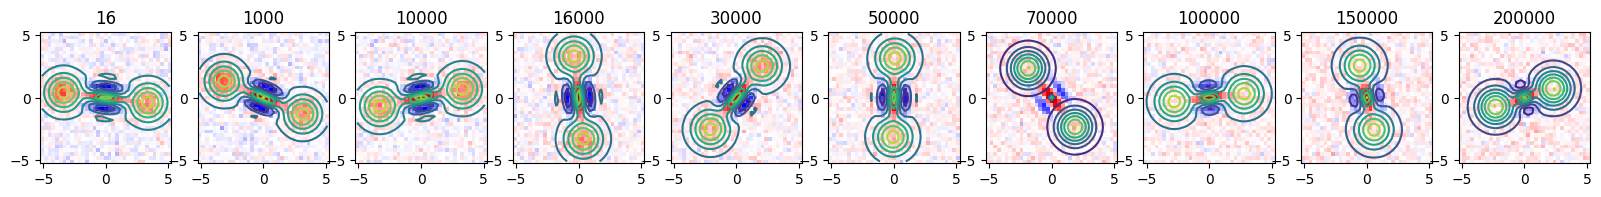

In [48]:
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

popts = []
angles = []

for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)

    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, 0.5, 0) # upper blob

        
    popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess)
    popts.append(popt)
    angles.append(popt[4])

    data_fitted1 = char_func_cat((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

In [49]:
print("First Blob")
print('amplitude:',popts[0][0])
print('sigmax:',popts[0][1])
print('sigmay:',popts[0][2])
print('beta:',popts[0][3] )
print("theta:",(popts[0][4]))
print("offset:",(popts[0][5]))


First Blob
amplitude: 0.818235180999236
sigmax: 0.8663873204609894
sigmay: 0.9343777086190708
beta: 1.6987496474390305
theta: 1.691937356481617
offset: -0.09848975595751255


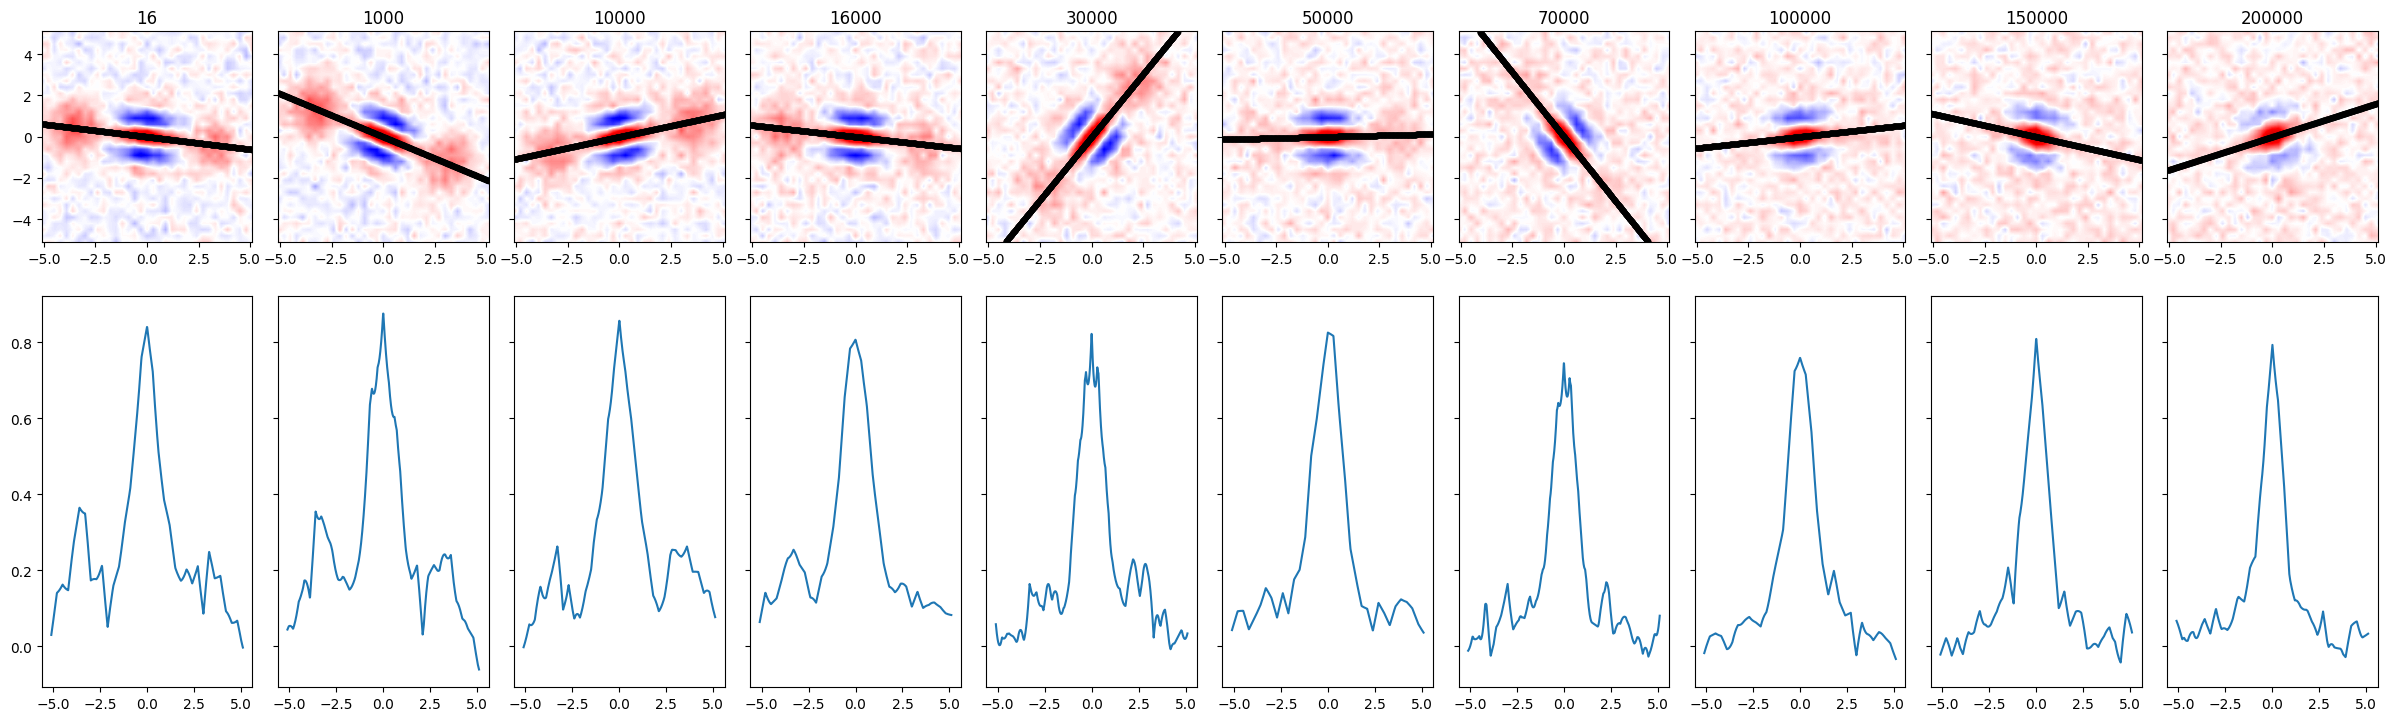

In [50]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))

cat_cut_array = []
for i, data in enumerate(data_array):
    angle = angles[i]
    if np.abs(angles[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    cat_cut_array.append(cut)

    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


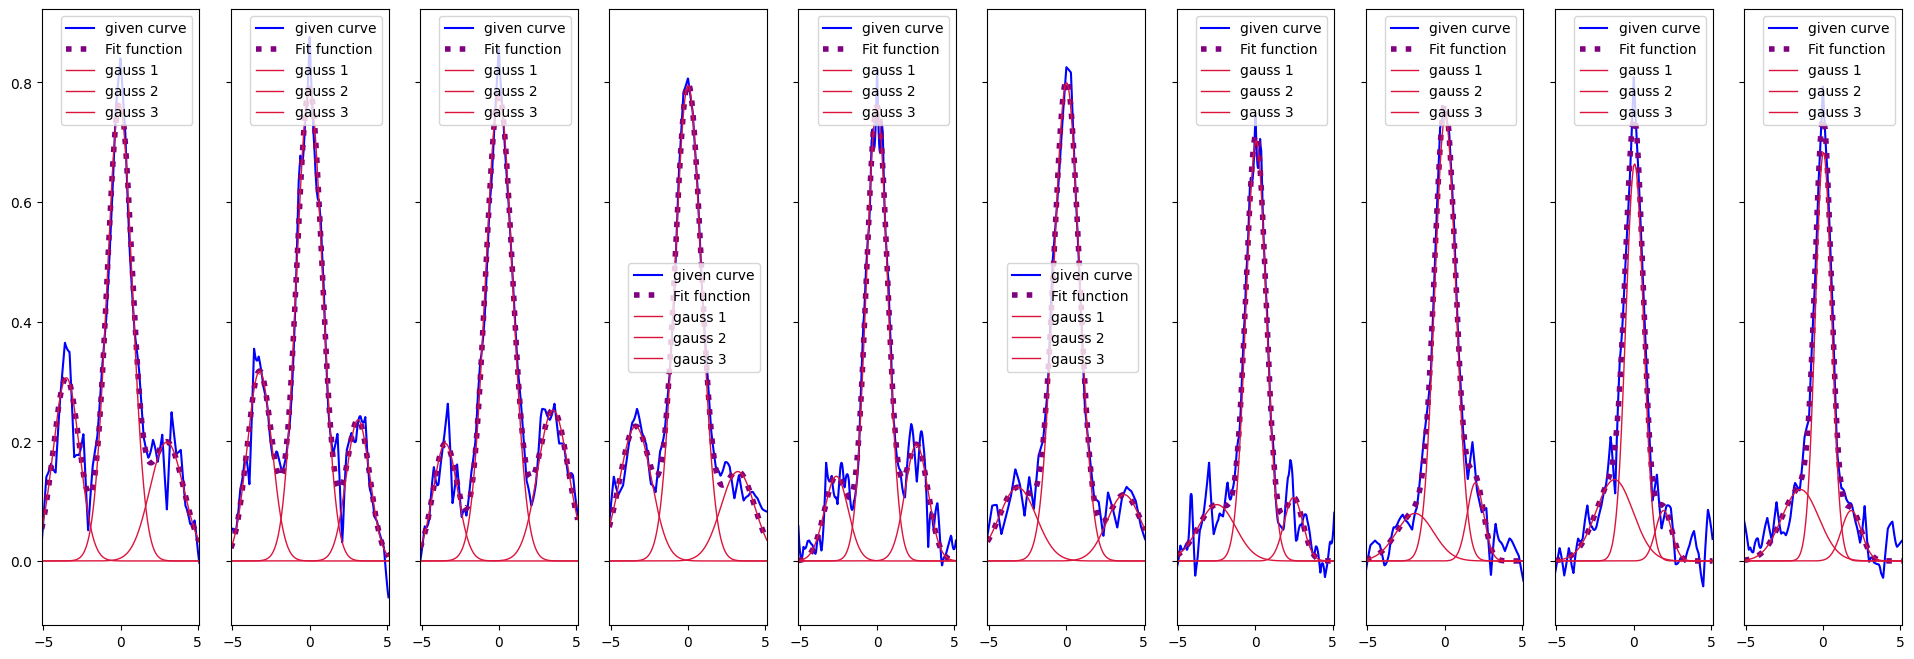

In [51]:

fig, axs = plt.subplots(1,len(cat_cut_array), sharey="row", figsize=(24,8))

fit_amp_cat = []
fit_amp_std_cat = []
for i, cut in enumerate(cat_cut_array):
    amp1 = 0.35
    sigma1 = 1
    cen1 = -3.5
    amp2 = 0.8
    sigma2 = 1
    cen2 = 0
    amp3 = 0.25
    sigma3 = 1
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds = ([-np.inf, -np.inf, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, 1.2,np.inf, np.inf, 1.2,np.inf, np.inf, 1.1 ]) 
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_cat.append((popt[0]+popt[6])/2)
    fit_amp_std_cat.append(np.sqrt(pcov[0][0]+pcov[6][6])/2) # take square root of averaged variances to find the std 
    
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


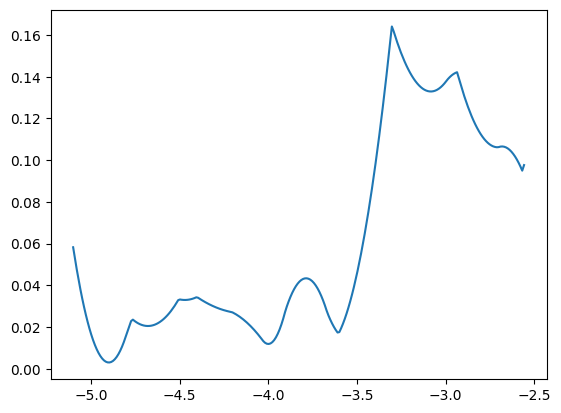

In [52]:
plt.plot(x_inter[0:250],cat_cut_array[4][0:250])
# blob_contrast_3dB = []

# for i in range(len(cat_cut_array)):
#     blob_contrast_3dB.append((np.max(cat_cut_array[i][:250] + np.max(cat_cut_array[i][250:])))/2)

## 3 dB

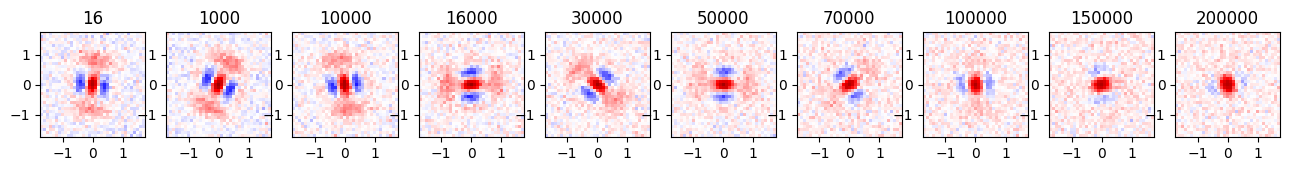

In [53]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '3db.h5'
x, y, data_array, decay_times = load_triple_mask_decay(path, file_end)

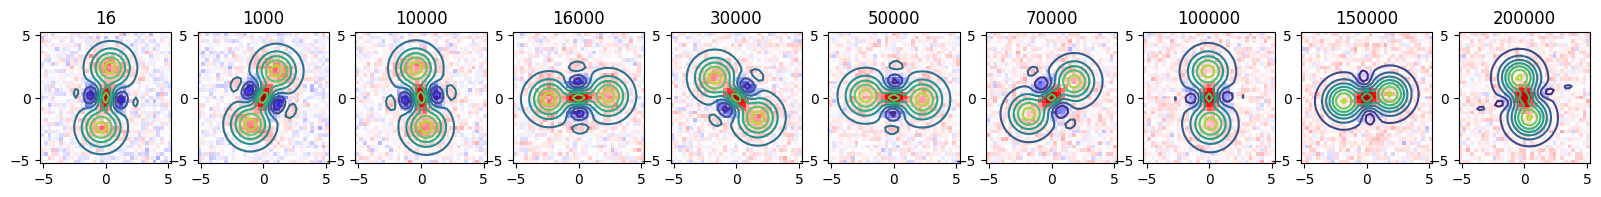

In [54]:
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

popts = []
angles = []

for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)
    
    # xy_angle = np.array(np.unravel_index(np.argmin(data, axis=None), data.shape)) - (np.unravel_index(np.argmax(data, axis=None), data.shape)) 
    # print(xy_angle)
    # theta0 = np.arctan(xy_angle[1]/xy_angle[0]) -np.pi/2
    # print(np.rad2deg(theta0))
    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, np.pi/2, 0) # upper blob
    
    # find the lowest and maximal point and substract their coordinates
  

        
    popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
    popts.append(popt)
    angles.append(popt[4])
    data_fitted1 = char_func_cat((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

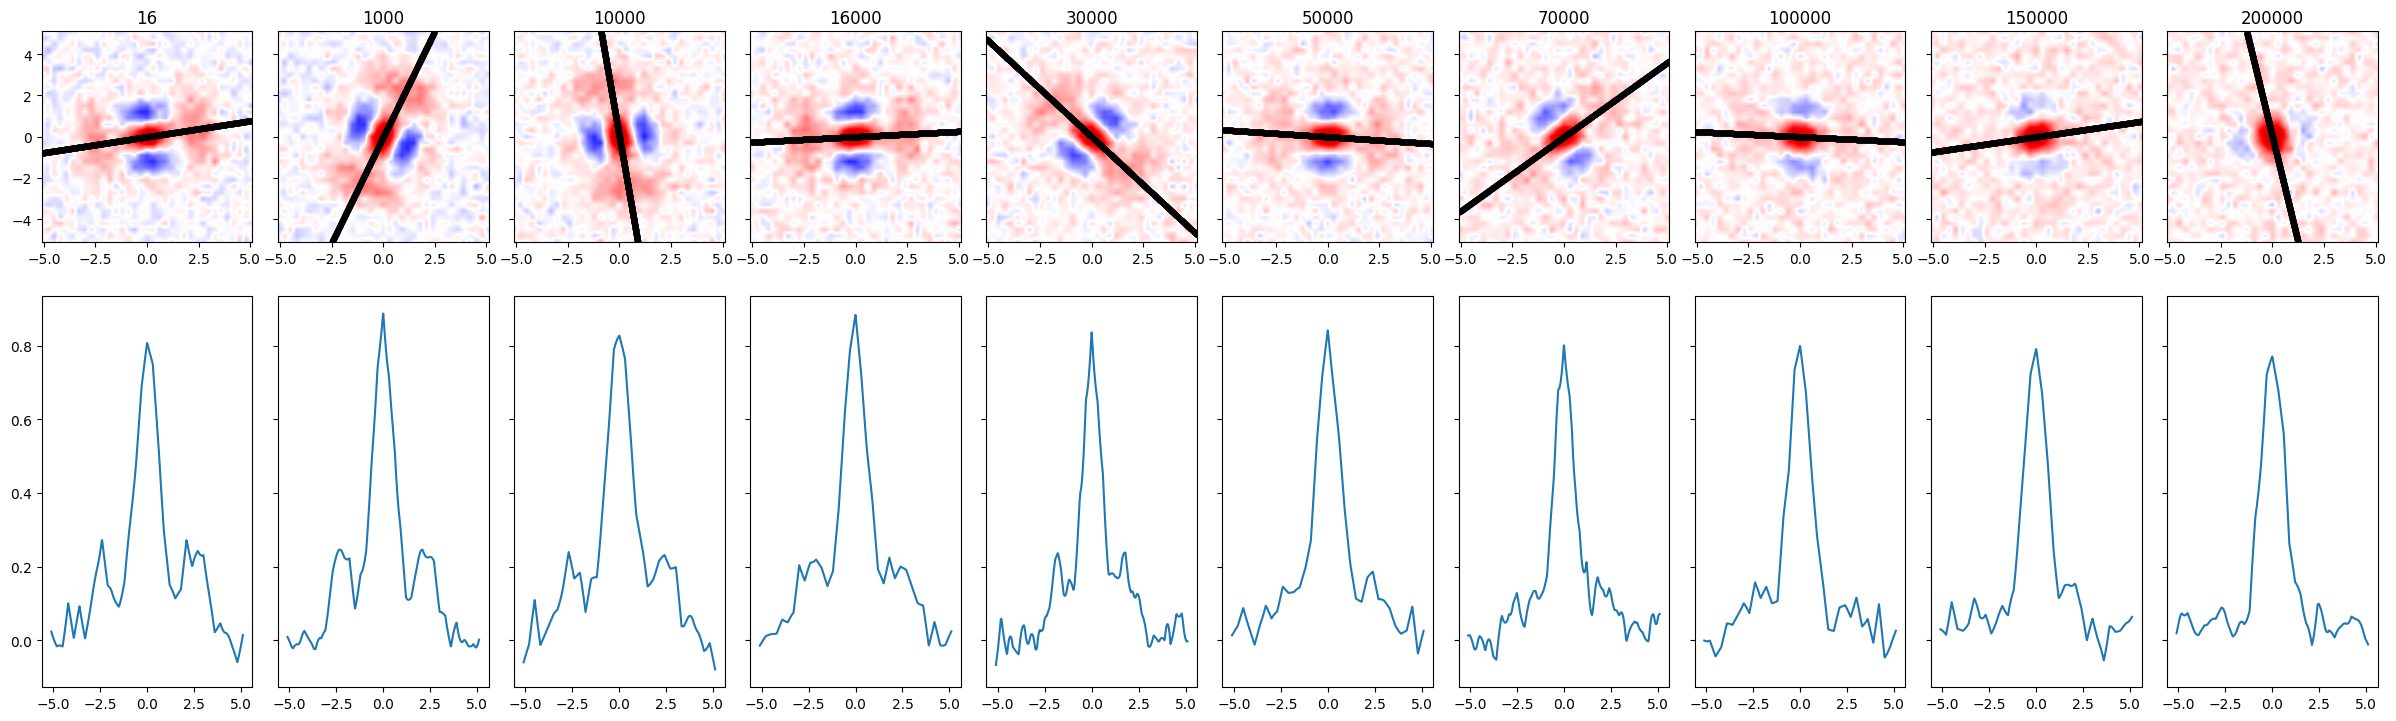

In [55]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))


db3_cut_array = []

for i, data in enumerate(data_array):
    angle = angles[i]
    if np.abs(angles[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    db3_cut_array.append(cut)
    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


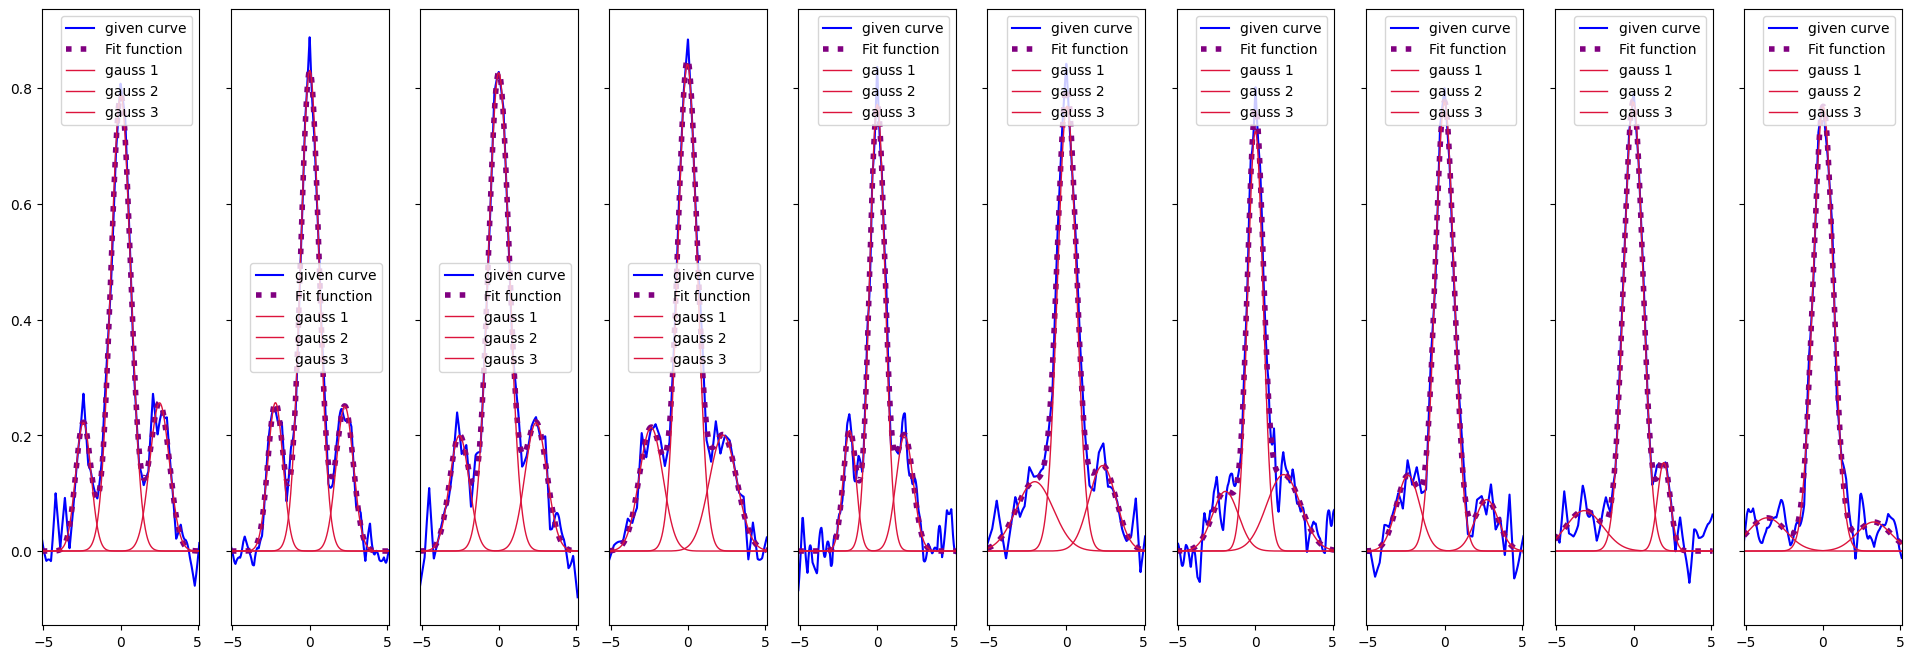

In [56]:

fig, axs = plt.subplots(1,len(db3_cut_array), sharey="row", figsize=(24,8))

fit_amp_3db = []
fit_amp_std_3db = []

for i, cut in enumerate(db3_cut_array):
    amp1 = 0.35
    sigma1 = 1
    cen1 = -3.5
    amp2 = 0.8
    sigma2 = 1
    cen2 = 0
    amp3 = 0.25
    sigma3 = 1
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds = ([-np.inf, -np.inf, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, 1.2,np.inf, np.inf, 1.2,np.inf, np.inf, 1.1 ]) 
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_3db.append((popt[0]+popt[6])/2)
    fit_amp_std_3db.append(np.sqrt(pcov[0][0]+pcov[6][6])/2)
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


In [ ]:
plt.plot(x_inter[0:350],db3_cut_array[4][0:350])
blob_contrast_3dB = []

for i in range(len(db3_cut_array)):
    blob_contrast_3dB.append((np.max(db3_cut_array[i][:350] + np.max(db3_cut_array[i][650:])))/2)

### Load 6dB data

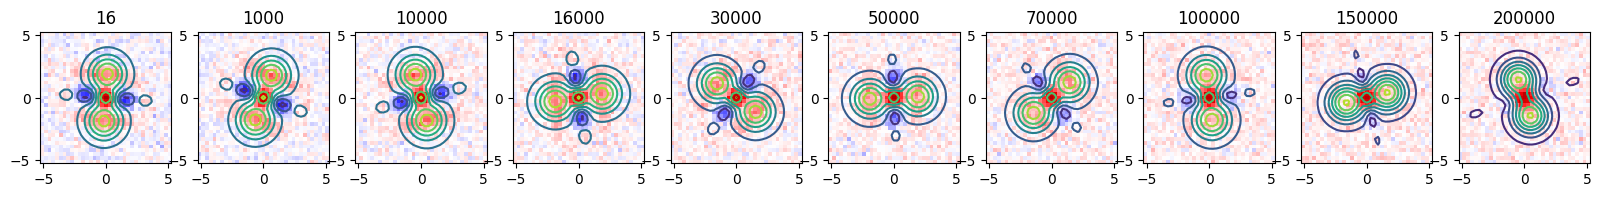

In [60]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '6db.h5'
x, y, data_array, decay_times = load_triple_mask_decay(path, file_end , plot=False)
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

popts = []
angles = []

for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)
    
    # xy_angle = np.array(np.unravel_index(np.argmin(data, axis=None), data.shape)) - (np.unravel_index(np.argmax(data, axis=None), data.shape)) 
    # print(xy_angle)
    # theta0 = np.arctan(xy_angle[1]/xy_angle[0]) -np.pi/2
    # print(np.rad2deg(theta0))
    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, np.pi/2, 0) # upper blob
    
    # find the lowest and maximal point and substract their coordinates
  

        
    popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess)
    popts.append(popt)
    angles.append(popt[4])
    data_fitted1 = char_func_cat((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

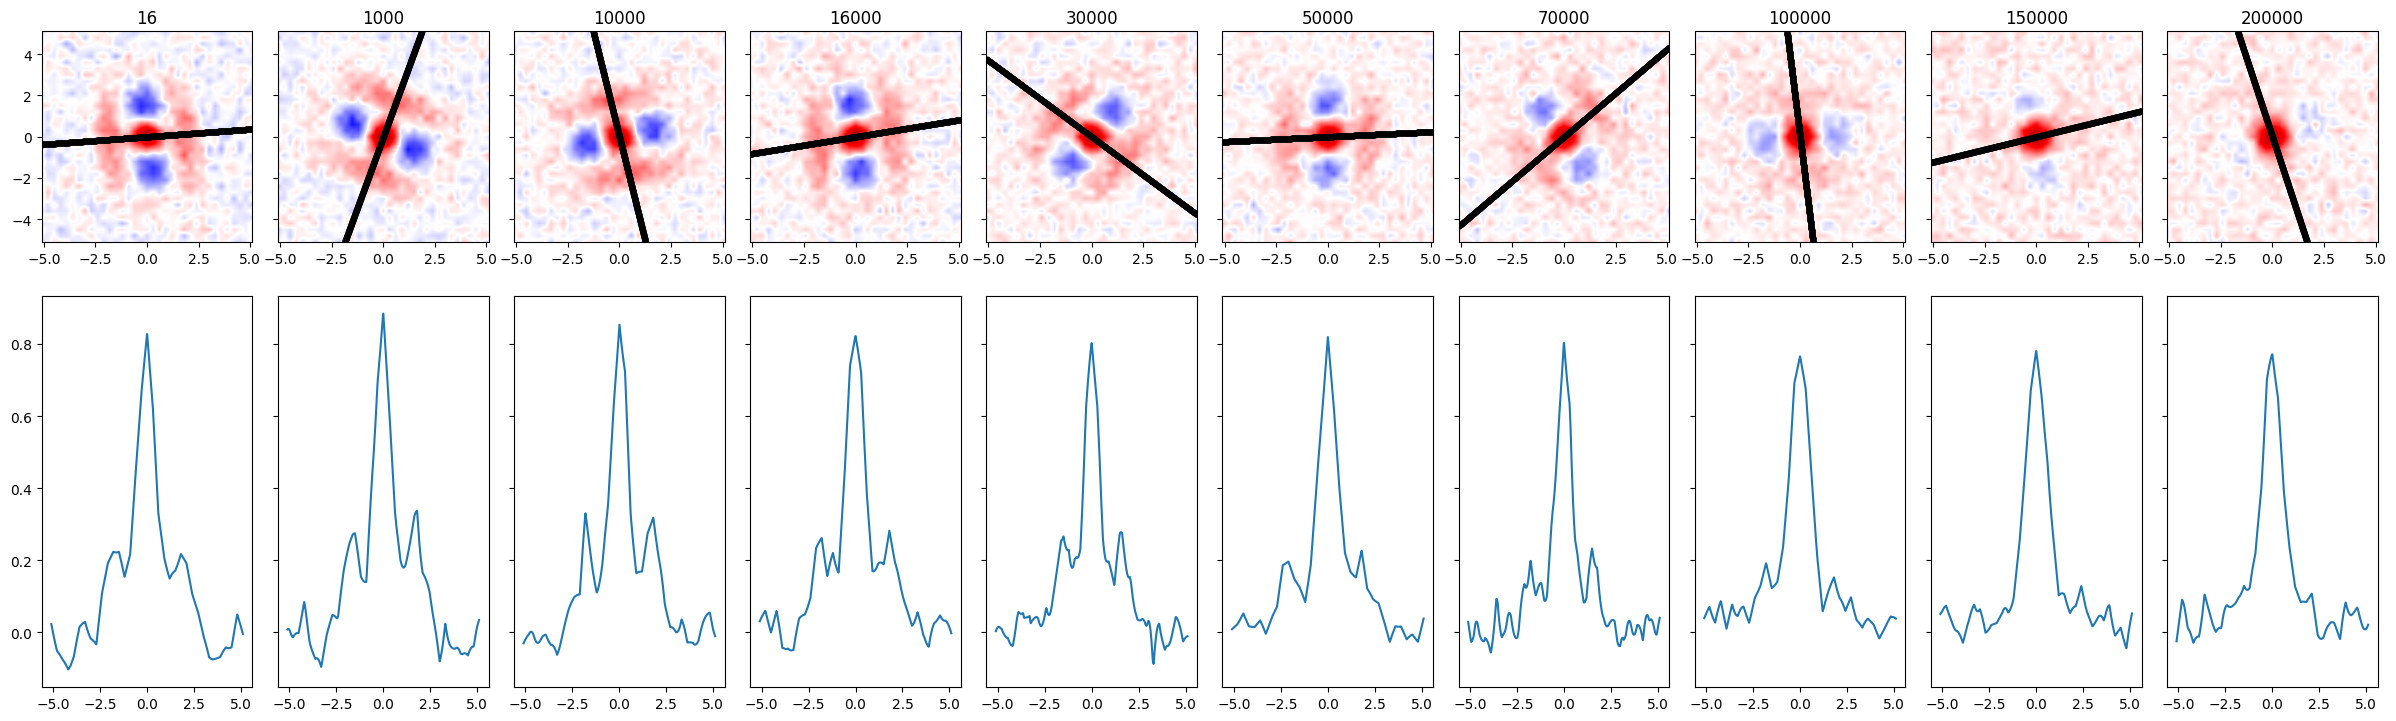

In [61]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))

db6_cut_array = []
for i, data in enumerate(data_array):
    angle = angles[i]
    if np.abs(angles[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    db6_cut_array.append(cut)
    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


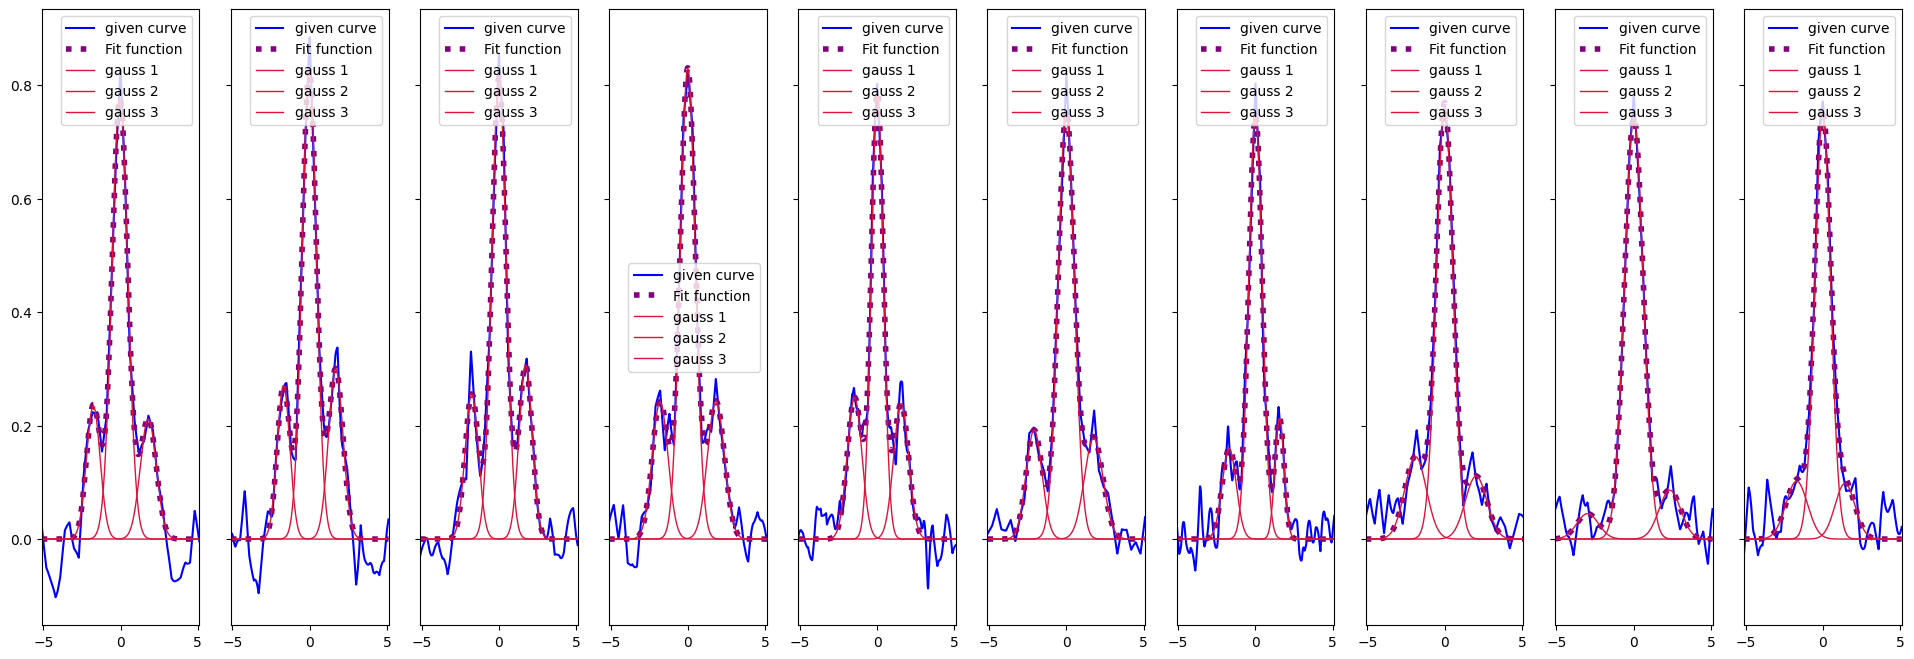

In [62]:

fig, axs = plt.subplots(1,len(db6_cut_array), sharey="row", figsize=(24,8))

fit_amp_6db = []
fit_amp_std_6db = []
for i, cut in enumerate(db6_cut_array):
    amp1 = 0.38
    sigma1 = 0.5
    cen1 = -2
    amp2 = 0.8
    sigma2 = 1
    cen2 = 0
    amp3 = 0.25
    sigma3 = 0.5
    cen3 = 2
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds = ([-np.inf, -np.inf, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, 0.7,np.inf, np.inf, 1.2,np.inf, np.inf, 0.7 ]) 
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_6db.append((popt[0]+popt[6])/2)
    fit_amp_std_6db.append(np.sqrt(pcov[0][0]+pcov[6][6])/2)
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


In [ ]:
plt.plot(x_inter[0:380],db6_cut_array[0][0:380])


In [164]:

blob_contrast_6db = []

for i in range(len(db6_cut_array)):
    blob_contrast_6db.append((np.max(db6_cut_array[i][:380] + np.max(db6_cut_array[i][620:])))/2)


## 7dB

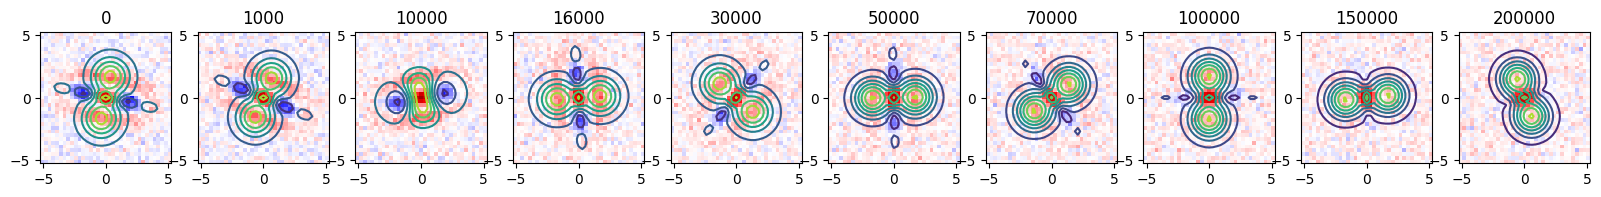

In [63]:
path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data/"
file_end = '7db.h5'
x, y, data_array, decay_times = load_triple_mask_decay(path, file_end , plot=False)
fig, axs = plt.subplots(1, len(data_array), figsize = (20, 20*len(data_array)))

popts = []
angles = []

for i, data in enumerate(data_array):
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    yvec = x*scaling
    X, Y = np.meshgrid(yvec, xvec)
    
    # xy_angle = np.array(np.unravel_index(np.argmin(data, axis=None), data.shape)) - (np.unravel_index(np.argmax(data, axis=None), data.shape)) 
    # print(xy_angle)
    # theta0 = np.arctan(xy_angle[1]/xy_angle[0]) -np.pi/2
    # print(np.rad2deg(theta0))
    #(xy_tuple, amplitude, sigma_x, sigma_y, beta_amp, theta, offset)
    initial_guess = (0.8,  0.8, 1, 1, np.pi/2, 0) # upper blob
    
    # find the lowest and maximal point and substract their coordinates
  

        
    popt, pcov = opt.curve_fit(char_func_cat, (X, Y), data.flatten(), p0=initial_guess)
    popts.append(popt)
    angles.append(popt[4])
    data_fitted1 = char_func_cat((X, Y), *popt)

    axs[i].pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
    axs[i].contour(yvec,xvec, data_fitted1.reshape(X.shape))
    axs[i].set_aspect("equal")
    axs[i].set_title(str(decay_times[i]))
plt.show()

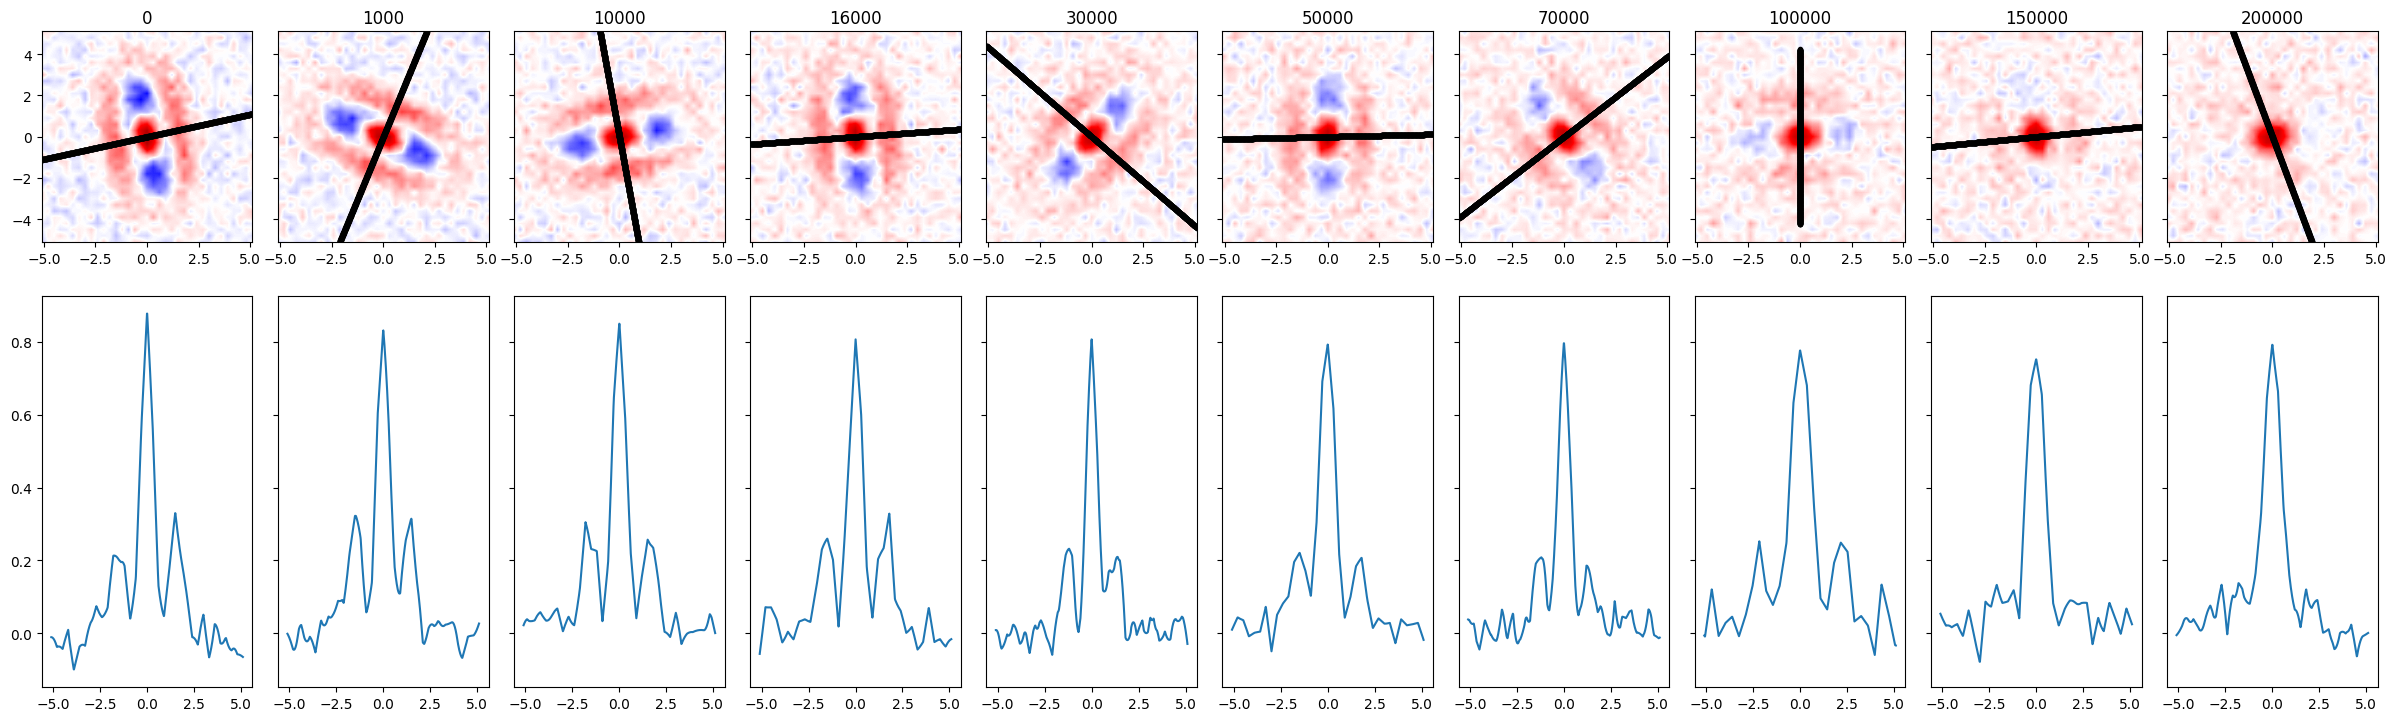

In [64]:

fig, axs = plt.subplots(2,len(data_array), sharey="row", figsize=(24,8))

db6_cut_array = []
for i, data in enumerate(data_array):
    angle = angles[i]
    if np.abs(angles[i])<np.deg2rad(15):
        data = data.T
        angle = np.pi/2-angles[i]
    #interpolate data
    func = interp2d(xvec,yvec,data, kind="linear")
    # define finer x,y arrays with same end values as data x,y
    x_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    y_inter = np.linspace(np.min(xvec),np.max(xvec), 1000)
    
    # get x and y indicies for line cut and load the line cut in cut
    x_index, y_index = cut_indexes(y_inter, np.pi/2-angle)
    cut = []
    for j in range(len(x_index)):
        cut.append(float(func(x_index[j],y_index[j])))
    db6_cut_array.append(cut)
    axs[0][i].set_aspect("equal")
    axs[0][i].pcolormesh(x_inter, y_inter, func(x_inter,x_inter), vmin=-1, vmax=1 , cmap="seismic")
    axs[0][i].scatter(x_index, y_index, c='k', marker = '.')
    axs[0][i].set_title(str(decay_times[i]))
    axs[1][i].plot(x_inter,cut)
    plt.tight_layout()
plt.show()
    


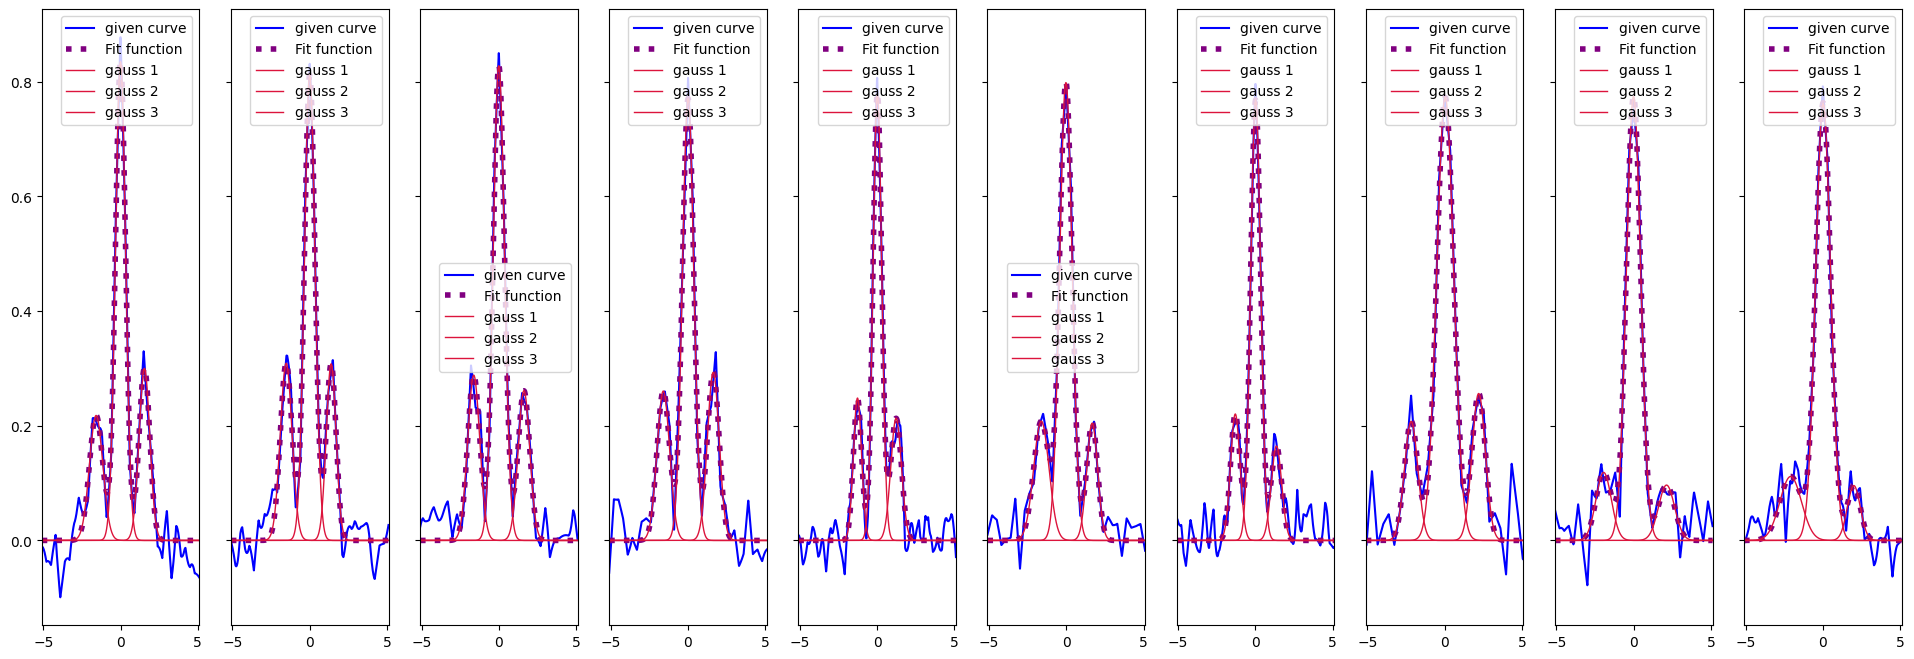

In [65]:

fig, axs = plt.subplots(1,len(db6_cut_array), sharey="row", figsize=(24,8))

fit_amp_7db = []
fit_amp_std_7db = []
for i, cut in enumerate(db6_cut_array):
    amp1 = 0.38
    sigma1 = 0.5
    cen1 = -2
    amp2 = 0.8
    sigma2 = 1
    cen2 = 0
    amp3 = 0.25
    sigma3 = 0.5
    cen3 = 2
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds = ([-np.inf, -np.inf, -np.inf,-np.inf, -np.inf, -0.9,-np.inf, -np.inf, -np.inf ],[np.inf, np.inf, 0.7,np.inf, np.inf, 1.2,np.inf, np.inf, 0.7 ]) 
       
    
    x = np.array(x_inter)
    y = np.array(cut)
    
    y0 = gauss_3(x, *initial_guess)

    popt, pcov = curve_fit(gauss_3, x, y, p0=initial_guess, bounds=bounds)
    fit_amp_7db.append((popt[0]+popt[6])/2)
    fit_amp_std_7db.append(np.sqrt(pcov[0][0]+pcov[6][6])/2)
    axs[i].plot(x, y, 'b', label="given curve")
    axs[i].plot(x, gauss_3(x, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(x, gauss_1(x, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


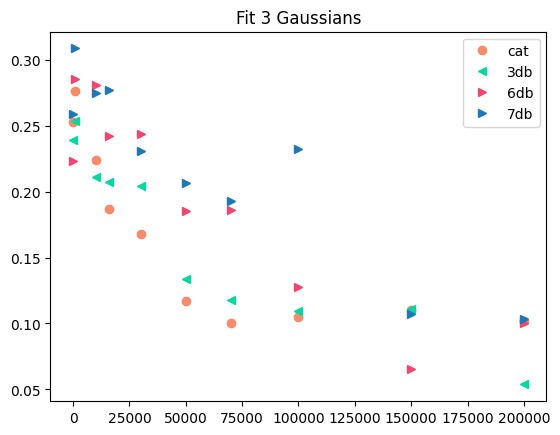

In [66]:


plt.plot(decay_times[:],fit_amp_cat[:], "o", label = "cat",color = '#f78c6b'  )
plt.plot(decay_times[:],fit_amp_3db[:], '<', label = "3db" , color = '#06d6a0')
plt.plot(decay_times[:],fit_amp_6db[:], '>', label = '6db', color = '#ef476f')
plt.plot(decay_times[:],fit_amp_7db[:], '>', label = '7db')
plt.title("Fit 3 Gaussians")
plt.legend()

<ErrorbarContainer object of 3 artists>

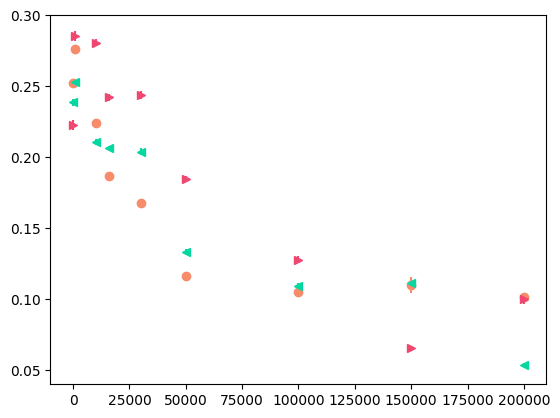

In [22]:
plt.errorbar(decay_times[decay_times!=70000][:],fit_amp_cat[:],  label = "cat",  yerr = fit_amp_std_cat[:], color = '#f78c6b',fmt = 'o'  )
plt.errorbar(decay_times[decay_times!=70000][:],fit_amp_3db[:],  label = "cat",  yerr = fit_amp_std_3db[:], color = '#06d6a0',  fmt='<')
plt.errorbar(decay_times[decay_times!=70000][:],fit_amp_6db[:],  label = "cat",  yerr = fit_amp_std_6db[:], color = '#ef476f',fmt='>')  

In [67]:
yvonne_lst = [decay_times, fit_amp_cat, fit_amp_3db, fit_amp_6db, fit_amp_7db]

In [68]:
np.save("3gaussian_fit",arr=yvonne_lst)